# Comparing Additional Training and Testing Runs
Additional training runs were completed.

In [33]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np

from repeating_classifier_training_utils import *

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
tia_path = '/data/WatChMaL/data/Best_ResNet18_Model/'
dump_dir = '/home/cmacdonald/CNN/dumps/'
repeat_path_1 = os.path.join(dump_dir,'20200506_104330')
repeat_path_2 = os.path.join(dump_dir,'20200521_134726')
repeat_path_3 = os.path.join(dump_dir,'20200522_145528')
repeat_path_4 = os.path.join(dump_dir,'20200522_153524')
paths = list([tia_path,repeat_path_1,repeat_path_2,repeat_path_3,repeat_path_4])
npz_path = os.path.join(os.getcwd(),'Index_Storage')

## Plot Training History

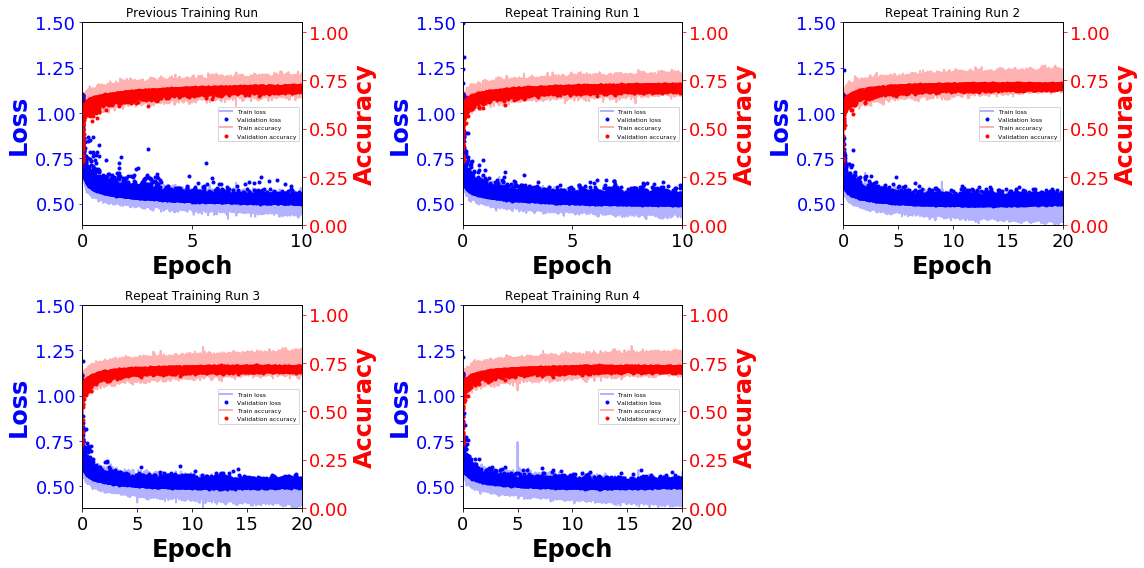

In [30]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Training Run' if i == 0 else 'Repeat Training Run {i}'.format(i=i) for i,_ in enumerate(paths)],leg_font=6)

## Plot Training History, Where Best Models Were Saved

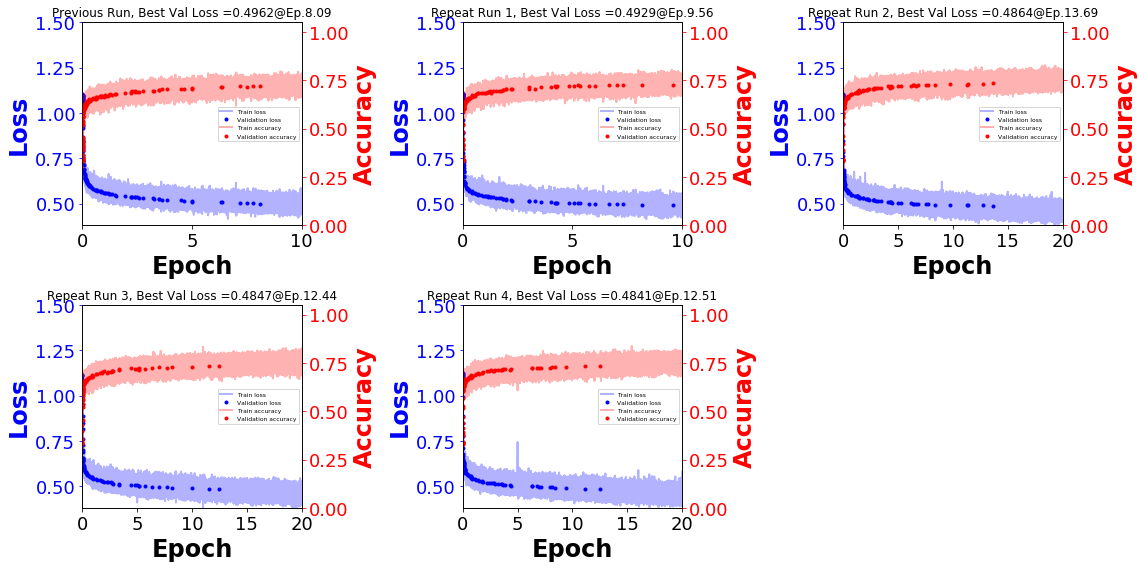

In [31]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)],best_only=True,leg_font=6)

## Plot Confusion Matrices

In [47]:
paths[0] =  "/home/cmacdonald/CNN/dumps/20200519_152505" #this was the test I ran with Tia's pretrained weights, but with sequential dataloader
test_output = [load_test_output(os.path.join(loc,'test_validation_iteration_dump.npz'),npz_path) for loc in paths]

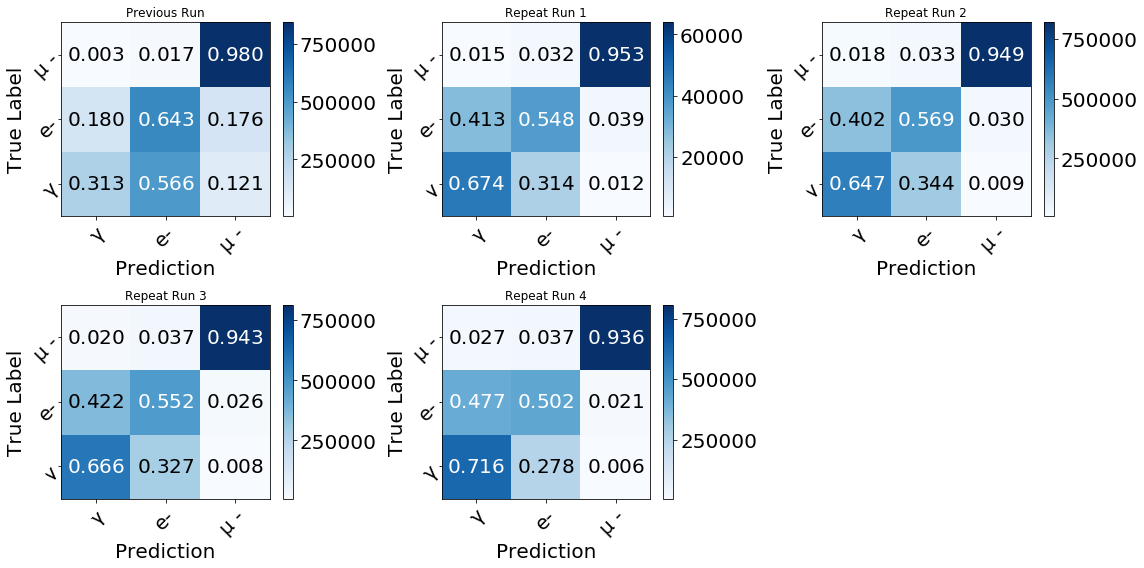

In [48]:
fig = plot_multiple_confusion_matrix([output['filtered_labels'] for output in test_output], [output['filtered_predictions'] for output in test_output],
                               ['\u03B3','e-','\u03BC -'],titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)])